In [1]:
import numpy as np
import torch
from ADEN import ADEN
from torchinfo import summary
from TestCaseGenerator import data_RLClustering
from ADENTrain import TrainAnneal
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading Data

In [2]:
X, M, T_P, N, d = data_RLClustering(4)
X = torch.tensor(X).float().to(device)
Y = torch.mean(X, dim=0).to(device) + torch.randn(M, d).to(
    device
)  # example cluster tensor (M, d)

# Loading ADEN Model

In [3]:

INPUT_DIM = d  # dimensionality of the input space
D_MODEL = 64  # dimensionality of the model
N_LAYERS = 3  # number of layers
N_HEADS = 8  # number of attention heads
D_FF = 128  # dimensionality of the feedforward network
DROPOUT = 0.1  # dropout rate

model = ADEN(
    input_dim=INPUT_DIM,
    d_model=D_MODEL,
    n_layers=N_LAYERS,
    n_heads=N_HEADS,
    d_ff=D_FF,
    dropout=DROPOUT,
    device=device
)

print(summary(model))

Layer (type:depth-idx)                             Param #
ADEN                                               --
├─Linear: 1-1                                      192
├─Linear: 1-2                                      192
├─ModuleList: 1-3                                  --
│    └─AdaptiveDistanceBlock: 2-1                  --
│    │    └─MultiHeadDistanceAttention: 3-1        16,448
│    │    └─LayerNorm: 3-2                         128
│    │    └─LayerNorm: 3-3                         128
│    │    └─Sequential: 3-4                        16,576
│    │    └─Dropout: 3-5                           --
│    └─AdaptiveDistanceBlock: 2-2                  --
│    │    └─MultiHeadDistanceAttention: 3-6        16,448
│    │    └─LayerNorm: 3-7                         128
│    │    └─LayerNorm: 3-8                         128
│    │    └─Sequential: 3-9                        16,576
│    │    └─Dropout: 3-10                          --
│    └─AdaptiveDistanceBlock: 2-3                  --
│

# Main Annealing Loop

In [4]:
# writing all hyperparameters in one place
EPOCHS_DBAR = 1000
BATCH_SIZE_DBAR = 32
NUM_SAMPLES_IN_BATCH_DBAR = 128
LR_DBAR = 1e-4
WEIGHT_DECAY_DBAR = 1e-5
TOL_TRAIN_DBAR = 1e-6
GAMMA_DBAR = 1000.0
PROBS_DBAR = torch.tensor(T_P)

EPOCHS_TRAIN_Y = 10000
BATCH_SIZE_TRAIN_Y = None
LR_TRAIN_Y = 1e-3
WEIGHT_DECAY_TRAIN_Y = 1e-5
TOL_TRAIN_Y = 1e-6

BETA_INIT = 1e-3
BETA_F = 10.0
BETA_GROWTH_RATE = 10.0
PERTURBATION_STD = 0.01


Y_opt, history = TrainAnneal(
    model,
    X,
    Y,
    device,
    # TrainDbar hyperparameters
    epochs_dbar=EPOCHS_DBAR,
    batch_size_dbar=BATCH_SIZE_DBAR,
    num_samples_in_batch_dbar=NUM_SAMPLES_IN_BATCH_DBAR,
    lr_dbar=LR_DBAR,
    weight_decay_dbar=WEIGHT_DECAY_DBAR,
    tol_train_dbar=TOL_TRAIN_DBAR,
    gamma_dbar=GAMMA_DBAR,
    probs_dbar=PROBS_DBAR,
    # trainY hyperparameters
    epochs_train_y=EPOCHS_TRAIN_Y,
    batch_size_train_y=BATCH_SIZE_TRAIN_Y,
    lr_train_y=LR_TRAIN_Y,
    weight_decay_train_y=WEIGHT_DECAY_TRAIN_Y,
    tol_train_y=TOL_TRAIN_Y,
    # annealing schedule
    beta_init=BETA_INIT,
    beta_final=BETA_F,
    beta_growth_rate=BETA_GROWTH_RATE,
    perturbation_std=PERTURBATION_STD,
)


=== Annealing step: Beta = 0.0010 ===
Epoch 0, MSE Loss: 188.549
Epoch 100, MSE Loss: 8.718
Epoch 200, MSE Loss: 3.532
Epoch 300, MSE Loss: 2.220
Epoch 400, MSE Loss: 1.769
Epoch 500, MSE Loss: 1.472
Epoch 600, MSE Loss: 1.291
Epoch 700, MSE Loss: 1.162
Epoch 800, MSE Loss: 1.065
Epoch 900, MSE Loss: 0.937
[trainY] Epoch 0, F: -2469877.500
[trainY] Epoch 100, F: -2470190.250
[trainY] Converged at epoch 134, F: -2470287.750

=== Annealing step: Beta = 0.0100 ===
Epoch 0, MSE Loss: 0.902
Epoch 100, MSE Loss: 0.478
Epoch 200, MSE Loss: 0.291
Epoch 300, MSE Loss: 0.193
Epoch 400, MSE Loss: 0.149
Epoch 500, MSE Loss: 0.119
Epoch 600, MSE Loss: 0.098
Epoch 700, MSE Loss: 0.078
Epoch 800, MSE Loss: 0.065
Epoch 900, MSE Loss: 0.053
[trainY] Epoch 0, F: -224675.922
[trainY] Epoch 100, F: -224928.219
[trainY] Epoch 200, F: -225144.672
[trainY] Epoch 300, F: -225331.000
[trainY] Epoch 400, F: -225490.812
[trainY] Epoch 500, F: -225627.094
[trainY] Epoch 600, F: -225742.781
[trainY] Epoch 700, F:

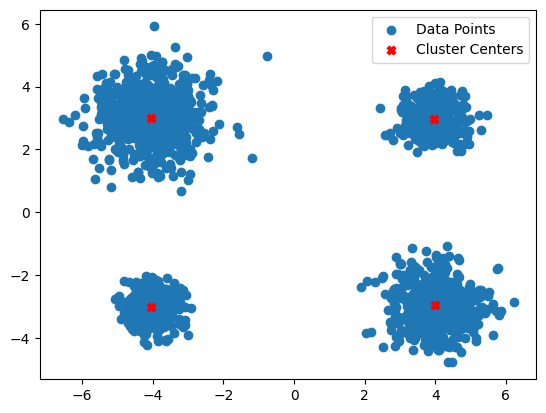

In [5]:
# plot locations of X and final y
import matplotlib.pyplot as plt
# converting results to numpy
X_np = X.detach().cpu().numpy()
y_np = Y_opt.detach().cpu().numpy()
plt.scatter(X_np[:, 0], X_np[:, 1], label='Data Points')
plt.scatter(y_np[:, 0], y_np[:, 1], label='Cluster Centers', marker='X', color='red')
plt.legend()
plt.show()